In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

<IPython.core.display.Javascript object>

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


<IPython.core.display.Javascript object>

In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 1.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [0, 1, 2, 3, 4, 5, 10]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 1e-2
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 9.79403e-06
condition number with pump: 0.20060097


In [7]:
#find the pump trajectories
params['s_size']    = 1e-2*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .1
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

D0: 0.011111111111111112
D0: 0.022222222222222223
D0: 0.03333333333333333
D0: 0.044444444444444446
D0: 0.05555555555555556
D0: 0.06666666666666667
D0: 0.07777777777777778
D0: 0.08888888888888889
D0: 0.1


In [8]:
#plot the pump trajectories
naq_u1.plot_pump_traj(Ks, Alphas, s, modes, new_modes)

<IPython.core.display.Javascript object>

In [9]:
params['s_size']    = 5e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 18/18 [00:57<00:00,  5.68s/it]


<IPython.core.display.Javascript object>


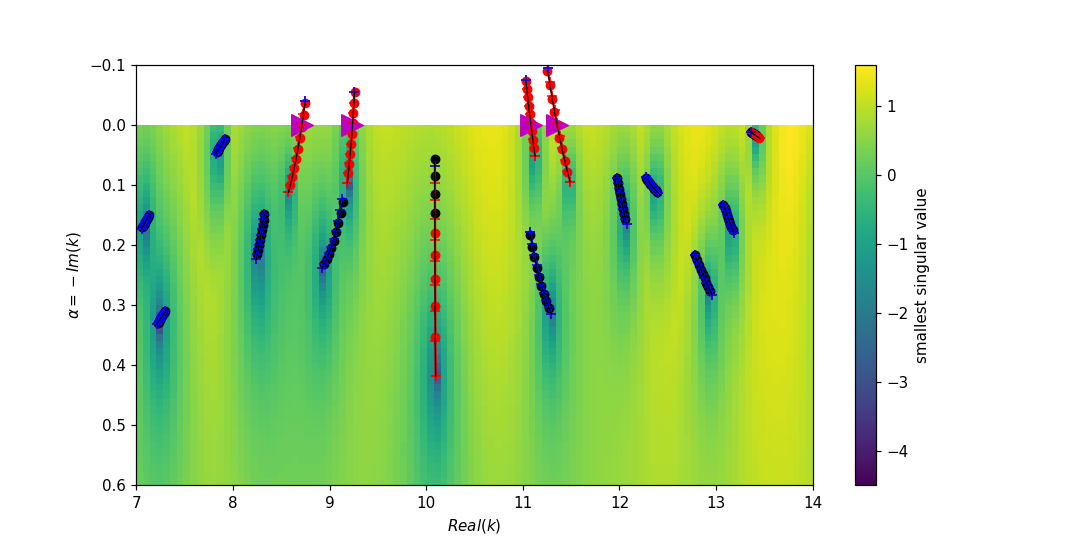

In [17]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=True)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later